<a href="https://colab.research.google.com/github/evroth/gsb545repo/blob/main/PA_Recurrent_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice Activity: Recurrent Neural Networks

Predict sales price of housing using a Kaggle dataset. The data transforms the raw sales data, re-sampling it at quarterly intervals with median price aggregation and step 4 moving average smoothing. We will be forecasting the Moving Average sales price for housing units of the same type and number of bedrooms.

In [38]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN

## The Data

In [2]:
hp = pd.read_csv("house_price.csv")

In [3]:
hp

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2
...,...,...,...,...
342,30/09/2018,603281,unit,3
343,31/12/2018,601167,unit,3
344,31/03/2019,605637,unit,3
345,30/06/2019,599339,unit,3


In [ ]:
hp.dtypes

saledate    object
MA           int64
type        object
bedrooms     int64
dtype: object

In [ ]:
hp.describe()

,MA,bedrooms
count,3.470000e+02,347.000000
mean,5.481320e+05,2.867435
std,1.701934e+05,1.239875
min,3.167510e+05,1.000000
25%,4.277395e+05,2.000000
50%,5.077440e+05,3.000000
75%,6.275155e+05,4.000000
max,1.017752e+06,5.000000


## EDA

In [ ]:
def plot_histograms(df):
    numeric_cols = df.select_dtypes(include='number').columns
    num_plots = len(numeric_cols)
    num_cols = 3  # Number of columns in the plot grid
    num_rows = (num_plots - 1) // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.ravel()  # Flatten the 2D axes array

    for i, col in enumerate(numeric_cols):
        axes[i].hist(df[col], bins='auto')
        axes[i].set_title(col)

    # Hide extra subplots if there are any
    for j in range(i+1, num_rows*num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

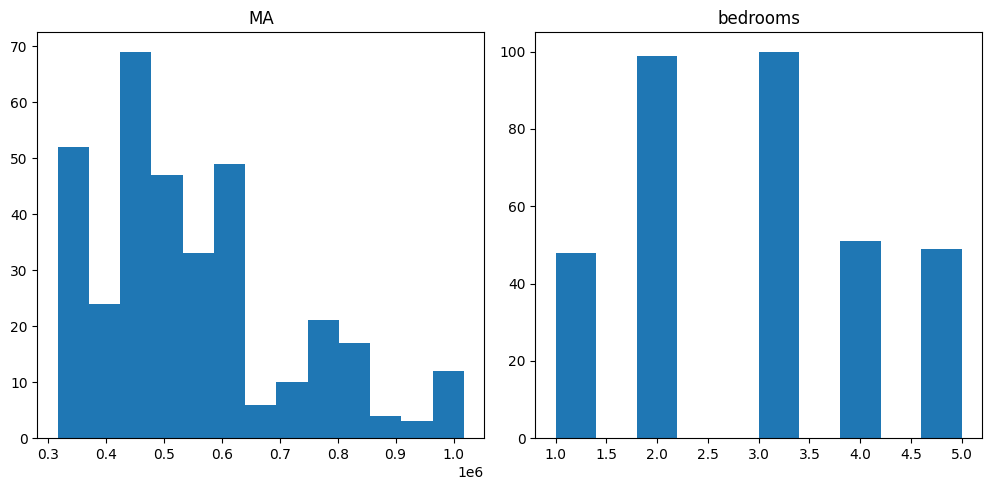

In [ ]:
plot_histograms(hp)

## Preprocess

In [4]:
le = LabelEncoder()
hp['type'] = le.fit_transform(hp['type'])

In [5]:
# Convert the "saledate" column to datetime
hp['saledate'] = pd.to_datetime(hp['saledate'], format='%d/%m/%Y')

In [6]:
# Create the "quarter" column based on the month
hp['quarter'] = hp['saledate'].dt.month.map({3: 1, 6: 2, 9: 3, 12: 4})

In [7]:
hp

,saledate,MA,type,bedrooms,quarter
0,2007-09-30,441854,0,2,3
1,2007-12-31,441854,0,2,4
2,2008-03-31,441854,0,2,1
3,2008-06-30,441854,0,2,2
4,2008-09-30,451583,0,2,3
...,...,...,...,...,...
342,2018-09-30,603281,1,3,3
343,2018-12-31,601167,1,3,4
344,2019-03-31,605637,1,3,1
345,2019-06-30,599339,1,3,2


## Building Models

In [52]:
# Sort the dataframe by "saledate" in ascending order
hp.sort_values('saledate', inplace=True)

# Calculate the index to split the data
split_index = int(len(hp) * 0.95)

# Split the data into train and test sets
train_df = hp.iloc[split_index:]
test_df = hp.iloc[:split_index]

# Data preprocessing: Normalize numerical features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_df[['quarter', 'bedrooms']])
X_test = scaler.transform(test_df[['quarter', 'bedrooms']])

y_train = scaler.fit_transform(train_df[['MA']])
y_test = scaler.transform(test_df[['MA']])

# Reshape input data for LSTM layer
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build the RNN model
model = Sequential()
model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

# Make predictions on test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('RMSE:', rmse)
print('R^2:', r2)

11/11 [==============================] - 1s 3ms/step
RMSE: 0.1423213583020765
R^2: 0.6885484950887691


In [53]:
# make predictions
# inverse tranforms expect as many columns as we had in original transformed dataset
trainPredict = model.predict(X_train)
trainPredict = np.insert(trainPredict, [1], np.zeros(2), axis = 1)
testPredict = model.predict(X_test)
testPredict = np.insert(testPredict, [1], np.zeros(2), axis = 1)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY2 = np.hstack((np.reshape(y_train, (len(y_train), 1)), np.zeros((len(y_train), 1))))
trainY2 = np.hstack((trainY2, np.zeros((len(y_train), 1))))
trainY2 = scaler.inverse_transform(trainY2)

testPredict = scaler.inverse_transform(testPredict)
testY2 = np.hstack((np.reshape(y_test, (len(y_test), 1)), np.zeros((len(y_test), 1))))
testY2 = np.hstack((testY2, np.zeros((len(y_test), 1))))
testY2 = scaler.inverse_transform(testY2)
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY2[:, 0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY2[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

11/11 [==============================] - 0s 2ms/step
Train Score: 28449.00 RMSE
Test Score: 93919.86 RMSE


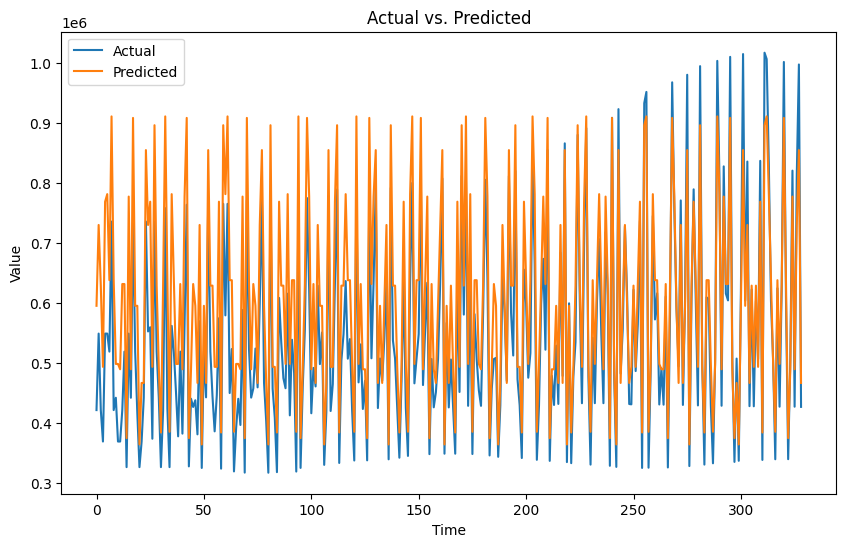

In [50]:
# Plotting the predictions
plt.figure(figsize=(10, 6))
plt.plot(testY2[:, 0], label='Actual')
plt.plot(testPredict[:, 0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

## Conclusion

This model is crap but I wanted to try to predict the MA house price with explanatory variables type and bedroom number. Different than the example we were shown in class. I am lost and not completely understanding how the inputs and shapes, etc work for these types of models